In [1]:
from drivecycle import route, simplification, energy
import pandas as pd
from matplotlib import pyplot
from scipy import interpolate
import json
import numpy as np
import inspect


In [2]:
stop_params = {
    "bus_stop":60,
    "tertiary":120,
    "secondary":180,
}

route_id=1
df = pd.read_json(f"../tests/data/calgary-{route_id}-edges.json")
df1 = simplification.cluster_nodes(df,30)
tvq = route.sequential(df1,stop_params, step=2, a_max=2)

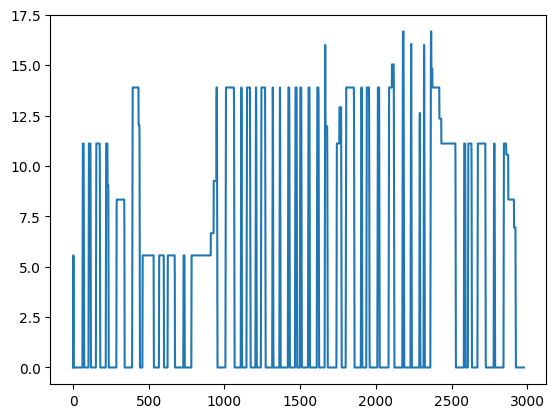

In [5]:
with open(f'../tests/data/calgary-{route_id}-elv.json', 'r') as f:
    elv = json.load(f)
    
e = energy.energy_model(tvq, elv, regen_ratio=0.3, m=10000)
pyplot.plot(e[:,0], e[:,1])

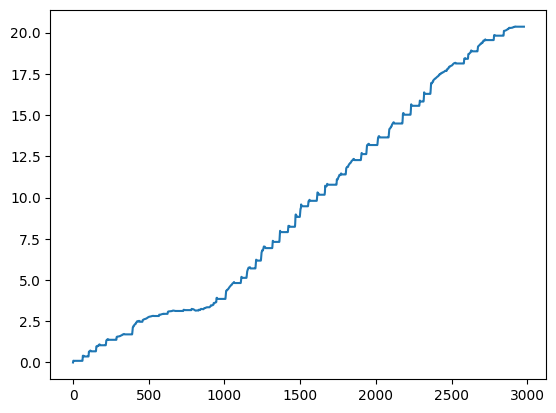

In [6]:
pyplot.plot(e[:,0], e[:,3])

In [170]:
def get_Einst(x,power_aux, **kwargs):
    trac_force_kwargs = list(inspect.signature(energy.tractive_force).parameters)
    force = energy.tractive_force(
        x["v1"],
        x["accel"],
        alpha=x["alpha"],
         **{
            i: kwargs[i]  # type: ignore
            for i in kwargs
            if i in trac_force_kwargs
            },
    )

    power_batt = energy.battery_power(
        x["v1"],
        force,
    )

    power = (power_batt / 1000) + power_aux  # Total power in kW
    return power * ((x["t1"] - x["t0"]) / 3600) 

In [171]:
list(inspect.signature(energy.tractive_force).parameters)

['v', 'accel', 'alpha', 'ch', 'm', 'air_density', 'cw', 'area']

In [172]:
def get_elv(x, elv_f):
    
    if elv_f is not None:
        d = x["d1"] - x["d0"]
        try:
            if d!=0:
                return (elv_f(x["d1"]) - elv_f(x["d0"])) / d
            else:
                return 0
        except (ValueError):  
            return 0
    else:
        return 0

1.199176748653509 -6.50493400910976


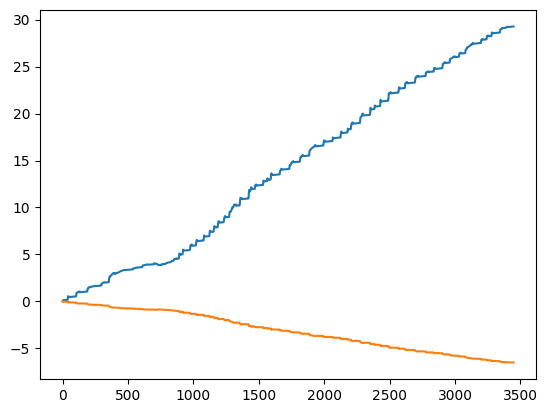

In [179]:
with open('../tests/data/calgary-1-elv.json', 'r') as f:
    elv = np.array(json.load(f))

def get_energy(tqv, elv=None, capacity=450, aux=0,**kwargs):
    elv_f = None
    if elv is not None:
        elv_f = interpolate.interp1d(elv[:,0],elv[:,1])
        
    
    df = pd.DataFrame(tvq, columns=["t0","v0","d0"])
    df["t1"] = df["t0"].shift(-1, fill_value=0)
    df["v1"] = df["v0"].shift(-1, fill_value=0)
    df["d1"] = df["d0"].shift(-1, fill_value=0)

    df["alpha"] = df.apply(lambda x: get_elv(x,elv_f), axis=1)


    df["accel"] = df.apply(lambda x: (x["v1"] - x["v0"]) / (x["t1"] - x["t0"]), axis=1)
    df["Einst"] = df.apply(lambda x: get_Einst(x,aux,**kwargs), axis=1)
    df["power"] = df["Einst"].cumsum()
    df["soc"] = (df["Einst"]/-capacity).cumsum()*100
    
    df = df[["t1","v1","d1","power","soc"]][:-1]
    
    return np.vstack((np.zeros((1,5)),df.to_numpy()))


e = get_energy(tvq,elv,aux=5, m=12000)
pyplot.plot(e[:,0], e[:,3])
print(e[-1,3]/(e[-1,2]/1000),e[-1,4])
pyplot.plot(e[:,0], e[:,4])

In [146]:
e.head()

,t1,v1,d1,power,soc
0,1.0,4.000,4.000000,0.068067,-0.015126
1,2.0,5.558,14.509159,0.127902,-0.028423
2,3.0,5.558,25.625159,0.130941,-0.029098
3,4.0,5.558,36.741159,0.133980,-0.029773
4,5.0,5.558,40.860000,0.137019,-0.030449


In [164]:
a = np.vstack((np.zeros((1,5)),e))


array([ 1.        ,  4.        ,  4.        ,  0.06806704, -0.01512601])